## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

*To clean the tokens, I'd start by removing punctuation and converting all text to lowercase. I would consider making a list of common words to also clean out. From there, I'd consider some kind of classifier (decision tree or logistic regression?) that could use word frequencies as features to predict whether or not an eemail is a scam. It would be a supervised learning task and I assume most of the variance would come from a few groups of words or phrases that contribute to predicting a spam email. Not sure how you'd one-hot encode a bunch of unique words.*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')

In [2]:
df['tokens'] = df['Email Text'].str.split()

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [3]:
import pickle

In [4]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

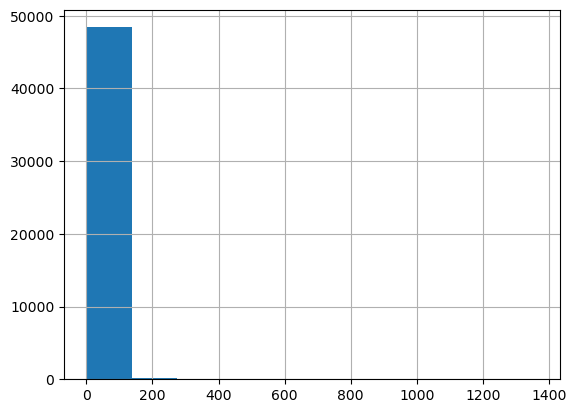

In [5]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist()
gdf['count'].describe()

There is a very long tail and most words are only said a couple of times. The average count of a word is 5 with a very low median, indicating that many words are used very infrequently.

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.


In [6]:
df = pd.read_parquet('/Users/willmayer/Desktop/DS3001/ds3001-PCA/05_PCA/Phishing_clean.parquet')

1. Perform an 80/20 train-test split of the data.


In [7]:
from sklearn.model_selection import train_test_split

y = df['Email Type']
X = df.drop('Email Type',axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
train_yhat = reg.predict(X_train)
test_yhat = reg.predict(X_test)


print('R2 on training set: ', r2_score(train_yhat, y_train))
print('R2 on test set: ', r2_score(test_yhat, y_test))    

R2 on training set:  0.6239427565216112
R2 on test set:  -8.90295962716614e-05


The model performs pretty well on the training set but very poorly on the test set, indicating overfitting. I would imagine that the model predicts email type based on unique words that might not appear in the test set.

3. What words have the largest coefficients in absolute value and most strongly influence predictions? 


In [11]:
x = pd.DataFrame({
    'Feature': reg.feature_names_in_,
    'Coefficient': reg.coef_ 
})
x['Coefficient'].nlargest(20)

96      1.036745e+13
1641    1.028527e+13
1798    8.685319e+12
1672    6.898793e+12
1445    6.705988e+12
915     6.105822e+12
1557    5.802553e+12
1721    5.438698e+12
1674    5.301161e+12
470     5.274893e+12
1573    4.023027e+12
2122    3.919395e+12
72      3.902365e+12
2487    3.764961e+12
1745    3.679381e+12
2054    2.810475e+12
822     2.730998e+12
33      1.686713e+12
668     1.677498e+12
1723    1.292243e+12
Name: Coefficient, dtype: float64

The best predictors are numbers which confirms this approach--the model doesn't know anything better than the data it was originally given.

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(X_train)

Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

<Axes: >

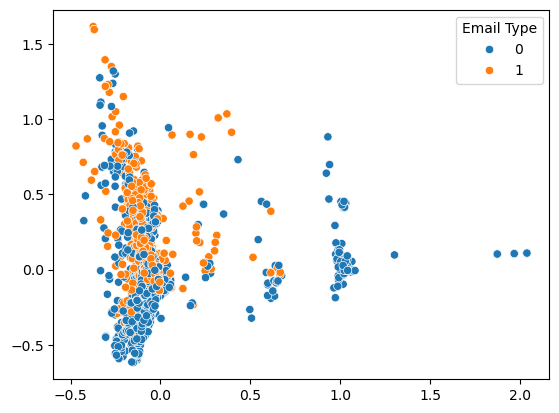

In [13]:
pc1 = Z_test[:, 0]
pc2 = Z_test[:, 1]

sns.scatterplot(x = pc1, y = pc2, hue=y_test)

Spam emails are between -0.5 to 0.25 in pc1 and between 0 and 1.5 in pc2

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [14]:
pca = PCA(n_components=2610).fit(X_train)

Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [15]:
reg1 = LinearRegression().fit(Z_train, y_train)
y_hat_test = reg1.predict(Z_test)
y_hat_train = reg1.predict(Z_train)

In [16]:
print('Train:', r2_score(y_hat_train,y_train) )
print('Test: ', r2_score(y_hat_test,y_test) )    

Train: 0.6967854877754096
Test:  0.5761002613787806


This model does much better on the test set, fixing the overfitting problem from before. It's also slightly better on the training set.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using PCA removes redundant/correlated features and prevents multicollinearity. The optimal number of PCs reduces the data to the unrelated variables that can better predict outcomes. For linear regression problems, without using PCA the model tries to reduce noise by attaching weight to specific, often correlated, variables that don't actually explain variance in whether the email is spam or not.